In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mengcius/cinic10
!unzip cinic10.zip -d /content/cinic10
!ls /content/cinic10

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: /content/cinic10/valid/truck/n03632852_11766.png  
  inflating: /content/cinic10/valid/truck/n03632852_11887.png  
  inflating: /content/cinic10/valid/truck/n03632852_1191.png  
  inflating: /content/cinic10/valid/truck/n03632852_1192.png  
  inflating: /content/cinic10/valid/truck/n03632852_1195.png  
  inflating: /content/cinic10/valid/truck/n03632852_1207.png  
  inflating: /content/cinic10/valid/truck/n03632852_12128.png  
  inflating: /content/cinic10/valid/truck/n03632852_1214.png  
  inflating: /content/cinic10/valid/truck/n03632852_1237.png  
  inflating: /content/cinic10/valid/truck/n03632852_1248.png  
  inflating: /content/cinic10/valid/truck/n03632852_1261.png  
  inflating: /content/cinic10/valid/truck/n03632852_1264.png  
  inflating: /content/cinic10/valid/truck/n03632852_1292.png  
  inflating: /content/cinic10/valid/truck/n03632852_1313.png  
  inflating: /content/cinic10/valid/truck/n0363285

# CNN

In [ ]:
# ========== IMPORTS ==========
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from google.colab import files
from tensorflow.keras import Model, Input
from tensorflow.keras.applications import ResNet50, EfficientNetV2B0, ConvNeXtTiny
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomZoom, RandomContrast, RandomRotation, Lambda
from tensorflow.keras.regularizers import l1
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import shutil

In [ ]:
# ========== CONFIG ==========
EPOCHS = 10
IMAGE_SIZE = (32, 32)
NUM_CLASSES = 10
LEARNING_RATES = [5e-4] #5e-4 - 1e-4, 3e-4, 1e-3
BATCH_SIZES = [128] #128 - 32 ,64, 128
DROPOUT_RATES = [0.5] #0.5 - 0.3, 0.5, 0.7
L1_REGS = [0.0] #0.0 - 0.0, 1e-5, 1e-4
AUGMENT_TYPES = ['none'] #'none' - 'none', 'rotation', 'contrast', 'zoom', 'cutmix'
FEW_SHOT_ENABLED = True
FEW_SHOT_SAMPLES_PER_CLASS = [10, 50, 200]

DATASET_PATH = "/content/cinic10"
TRAIN_DIR = DATASET_PATH + "/train"
VALID_DIR = DATASET_PATH + "/valid"
TEST_DIR = DATASET_PATH + "/test"
RESULTS_DIR = "/content/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
# ========== CUTMIX ==========
def cutmix(image_batch, label_batch, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = tf.shape(image_batch)[0]
    idx = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(image_batch, idx)
    shuffled_labels = tf.gather(label_batch, idx)
    h, w = IMAGE_SIZE
    r_x = tf.cast(tf.random.uniform([], 0, w), tf.int32)
    r_y = tf.cast(tf.random.uniform([], 0, h), tf.int32)
    r_w = tf.cast(w * tf.math.sqrt(1. - lam), tf.int32)
    r_h = tf.cast(h * tf.math.sqrt(1. - lam), tf.int32)
    x1 = tf.clip_by_value(r_x - r_w // 2, 0, w)
    y1 = tf.clip_by_value(r_y - r_h // 2, 0, h)
    x2 = tf.clip_by_value(r_x + r_w // 2, 0, w)
    y2 = tf.clip_by_value(r_y + r_h // 2, 0, h)
    crop = shuffled_images[:, y1:y2, x1:x2, :]
    paddings = [[0, 0], [y1, h - y2], [x1, w - x2], [0, 0]]
    patch = tf.pad(crop, paddings, constant_values=0)
    mixed = image_batch * (1 - tf.cast(tf.pad(tf.ones_like(crop), paddings), tf.float32)) + patch
    lam_adj = 1 - ((x2 - x1) * (y2 - y1)) / (h * w)
    lam_adj = tf.cast(lam_adj, tf.float32)
    label_batch = lam_adj * label_batch + (1 - lam_adj) * shuffled_labels
    return mixed, label_batch

In [ ]:
# ========== DATA LOADER ==========
def get_data(batch_size, augmentation=None, few_shot_samples=None):
    train = image_dataset_from_directory(TRAIN_DIR, image_size=IMAGE_SIZE, batch_size=batch_size, label_mode='categorical', seed=123)
    if FEW_SHOT_ENABLED and few_shot_samples:
        train = train.unbatch()
        train = train.take(few_shot_samples * NUM_CLASSES)
        train = train.batch(batch_size)
    valid = image_dataset_from_directory(VALID_DIR, image_size=IMAGE_SIZE, batch_size=batch_size, label_mode='categorical', seed=123)
    test = image_dataset_from_directory(TEST_DIR, image_size=IMAGE_SIZE, batch_size=batch_size, label_mode='categorical', seed=123)
    if augmentation == 'cutmix':
        train = train.map(lambda x, y: cutmix(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    return train, valid, test

In [ ]:
# ========== AUGMENTATION LAYER ==========
def get_augmentation_layer(aug_type):
    if aug_type == 'rotation':
        return tf.keras.Sequential([RandomRotation(0.085)])
    elif aug_type == 'contrast':
        return tf.keras.Sequential([RandomContrast(0.2)])
    elif aug_type == 'zoom':
        return tf.keras.Sequential([RandomZoom(0.1)])
    else:
        return tf.keras.Sequential([])

In [ ]:
# ========== MODEL ==========
def build_model(base_model, dropout_rate, l1_reg, aug_type, model_name):
    inputs = Input(shape=(32, 32, 3))
    if model_name == 'ResNet50':
        x = Lambda(resnet_preprocess)(inputs)
    elif model_name == 'EfficientNetV2B0':
        x = Lambda(efficientnet_preprocess)(inputs)
    elif model_name == 'ConvNeXtTiny':
        x = Lambda(convnext_preprocess)(inputs)
    if aug_type in ['rotation', 'contrast', 'zoom']:
        x = get_augmentation_layer(aug_type)(x)
    base_model.trainable = False
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l1(l1_reg))(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=inputs, outputs=outputs, name=base_model.name)

In [ ]:
# ========== TRAINING ==========
results = []
trained_models = []
model_classes = {
    'ResNet50': ResNet50,
    'EfficientNetV2B0': EfficientNetV2B0,
    'ConvNeXtTiny': ConvNeXtTiny
}

for model_name in model_classes:
    for lr in LEARNING_RATES:
        for bs in BATCH_SIZES:
            for dr in DROPOUT_RATES:
                for l1r in L1_REGS:
                    for aug in AUGMENT_TYPES:
                        for few_shot_count in (FEW_SHOT_SAMPLES_PER_CLASS if FEW_SHOT_ENABLED else [None]):
                            few_shot_label = few_shot_count if FEW_SHOT_ENABLED else "full"
                            print(f"\n>>> Training {model_name} | LR={lr}, BS={bs}, DO={dr}, L1={l1r}, AUG={aug}, FEW_SHOT={few_shot_label}")
                            train_ds, val_ds, test_ds = get_data(bs, augmentation=aug, few_shot_samples=few_shot_count)
                            base_model = model_classes[model_name](include_top=False, weights='imagenet', input_shape=IMAGE_SIZE + (3,))
                            model = build_model(base_model, dropout_rate=dr, l1_reg=l1r, aug_type=aug, model_name=model_name)
                            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
                            steps_per_epoch = (few_shot_count * NUM_CLASSES) // bs if FEW_SHOT_ENABLED and few_shot_count else None
                            history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, verbose=1)
                            filename_prefix = f"{model_name}_lr{lr}_bs{bs}_do{dr}_l1{l1r}_aug{aug}_fs{few_shot_label}"
                            model.save(f"{RESULTS_DIR}/{filename_prefix}.keras")
                            plt.figure()
                            plt.plot(history.history['accuracy'], label='Train Accuracy')
                            plt.plot(history.history['val_accuracy'], label='Val Accuracy')
                            plt.title(filename_prefix)
                            plt.xlabel('Epoch')
                            plt.ylabel('Accuracy')
                            plt.grid()
                            plt.legend()
                            plt.savefig(f"{RESULTS_DIR}/{filename_prefix}_acc.png")
                            plt.close()
                            test_loss, test_acc = model.evaluate(test_ds, verbose=0)
                            preds = model.predict(test_ds, verbose=0)
                            trained_models.append({'name': model.name, 'model': model, 'preds': preds})
                            for epoch in range(EPOCHS):
                                results.append({
                                    'model': model.name,
                                    'learning_rate': lr,
                                    'batch_size': bs,
                                    'dropout': dr,
                                    'l1_reg': l1r,
                                    'augmentation': aug,
                                    'few_shot': few_shot_label,
                                    'epoch': epoch + 1,
                                    'train_loss': history.history['loss'][epoch],
                                    'train_accuracy': history.history['accuracy'][epoch],
                                    'val_loss': history.history['val_loss'][epoch],
                                    'val_accuracy': history.history['val_accuracy'][epoch],
                                    'test_loss': test_loss,
                                    'test_acc': test_acc
                                })


>>> Training ResNet50 | LR=0.0005, BS=128, DO=0.5, L1=0.0, AUG=none, FEW_SHOT=10
Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.
Epoch 1/10
      1/Unknown 14s 14s/step - accuracy: 0.1200 - loss: 6.4982

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - accuracy: 0.1200 - loss: 6.4982 - val_accuracy: 0.1476 - val_loss: 4.1788
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1300 - loss: 5.0178 - val_accuracy: 0.1880 - val_loss: 4.1614
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1500 - loss: 5.9179 - val_accuracy: 0.2185 - val_loss: 3.8816
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1700 - loss: 5.4793 - val_accuracy: 0.2543 - val_loss: 3.3366
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2500 - loss: 3.6633 - val_accuracy: 0.2781 - val_loss: 3.0262
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2700 - loss: 3.5096 - val_accuracy: 0.2958 - val_loss: 2.8579
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2700 - loss: 3.6641 - val_accuracy: 0.3065 - val_loss: 2.8713
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3300 - loss: 3.3586 - val_accuracy: 0.3132 - val_loss: 2.9209
Epoch 9/10
1/1 ━━━━━━━━━━

In [ ]:
# ========== SAVE RESULTS ==========
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(RESULTS_DIR, "summary_results_final.csv"), index=False)

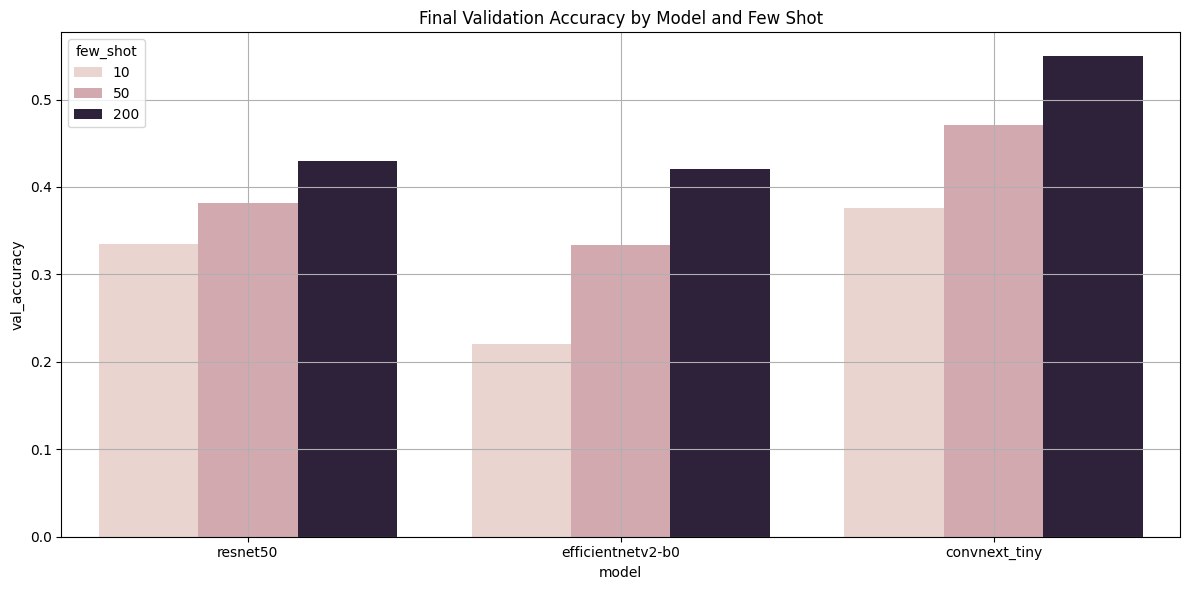

In [ ]:
# ========== FINAL PLOT ==========
plt.figure(figsize=(12, 6))
final_df = results_df[results_df["epoch"] == EPOCHS]
sns.barplot(data=final_df, x="model", y="val_accuracy", hue="few_shot")
plt.title("Final Validation Accuracy by Model and Few Shot")
plt.grid()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/final_plot_model_vs_few_shot.png")
plt.show()

In [ ]:
shutil.make_archive("/content/results", 'zip', "/content/results")
files.download("/content/results.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>